# Numba

[Numba](https://numba.pydata.org/) is an open source JIT compiler that translates a subset of Python and NumPy code into fast machine code.

In [2]:
import numpy as np
from numba import njit, prange
from matplotlib import pyplot as plt

In [1]:
xmin = -1.5
ymin = -1.0
xmax = 0.5
ymax = 1.0
resolution = 300
xstep = (xmax - xmin) / resolution
ystep = (ymax - ymin) / resolution
xs = [(xmin + xstep * i) for i in range(resolution)]
ys = [(ymin + ystep * i) for i in range(resolution)]

## Trivial implementation

Add a Numba decorator to the trivial python implementation from notebook ```09_00_performance_programming.ipynb```. Note that ```@njit``` is equivalent to ```@jit(nopython=True)```. This provides an approximately 10x increase in performance. 

In [3]:
@njit
def mandel_numba(position, limit=50):
    value = position
    while abs(value) < 2:
        limit -= 1
        value = value ** 2 + position
        if limit < 0:
            return 0
    return limit

In [4]:
%%timeit
data_numba = [[mandel_numba(complex(x, y)) for x in xs] for y in ys]

33.6 ms ± 1.36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


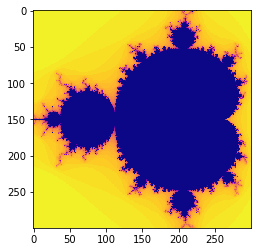

In [5]:
data_numba = [[mandel_numba(complex(x, y)) for x in xs] for y in ys]
plt.imshow(data_numba, interpolation="none", cmap="plasma")

## Optimised implementation

Starting with ```numpy_cython_1```, the best Cython solution available in notebook ```09_03_cython.ipynb```, we can significantly improve the performance by parallelizing the for loop using the ```prange``` operator. The user is required to make sure that the loop does not have cross iteration dependencies except for supported reductions. This solution is approximately 6x faster than the best cython implementation and is simpler to implement.

In [6]:
@njit(parallel=True)
def mandel_numba_optimised(position, limit=50):
    
    xlim = position.shape[1]
    ylim = position.shape[0]
    diverged_at = np.zeros((ylim, xlim))
    
    for x in prange(xlim):
        for y in range(ylim):
            steps = limit
            value = position[y,x]
            pos = position[y,x]
            while abs(value) < 2 and steps >= 0:
                steps -= 1
                value = value**2 + pos
            diverged_at[y, x] = steps
  
    return diverged_at

In [7]:
ymatrix, xmatrix = np.mgrid[ymin:ymax:ystep, xmin:xmax:xstep]
values = xmatrix + 1j * ymatrix

In [8]:
%%timeit
data_numba_optimised = mandel_numba_optimised(values)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


1.65 ms ± 96.1 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


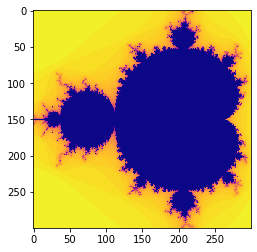

In [9]:
data_numba_optimised = mandel_numba_optimised(values)
plt.imshow(data_numba_optimised, interpolation="none", cmap="plasma")